In [16]:
import h5py
import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
!wget https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

--2022-11-14 09:01:53--  https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G) [text/plain]
Saving to: ‘Galaxy10_DECals.h5’

Galaxy10_DECals.h5  100%[===================>]   2.55G  77.6MB/s    in 36s     

2022-11-14 09:02:29 (72.8 MB/s) - ‘Galaxy10_DECals.h5’ saved [2735267419/2735267419]



In [22]:
# Get milky way similar galaxies
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
  labels = np.array(F['ans'])
  # Milky way similar galaxies are class '6'
  (milkywaylikes_idx,) = np.where(labels == 6)
  images = np.array(F['images'][milkywaylikes_idx])

images = images.astype(np.float32) / 255.

print(images.shape)

(1829, 256, 256, 3)


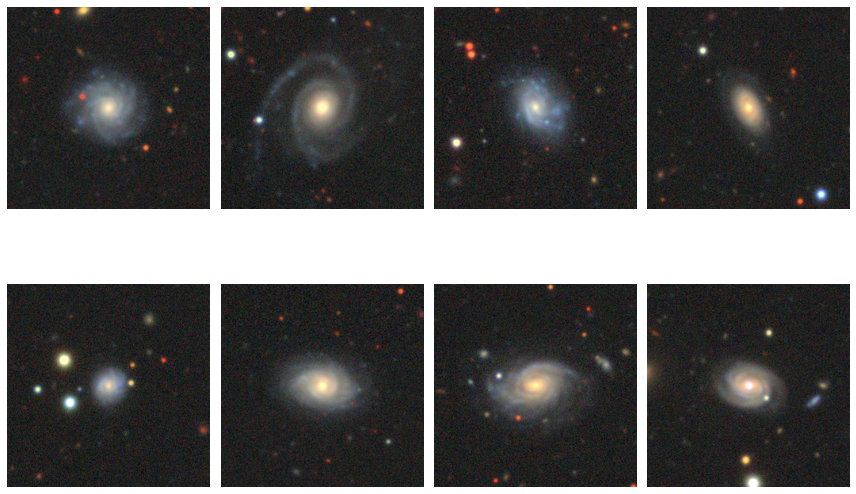

In [34]:
%matplotlib inline

def show_galaxies(images: np.ndarray) -> None:
  n = len(images)
  # always 4 in a column
  ncols = 4
  nrows = -(-n // ncols)
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

  for img, ax in zip(images, axes.ravel()):
    ax.imshow(img)
    ax.axis('off')
    fig.tight_layout()

# plot first 8 images
show_galaxies(images[:8])